In [ ]:
import numpy as np
import scipy
import random
import pandas as pd
from collections import Counter
import os
from sklearn.metrics import pairwise_distances
import copy
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Data Preprocessing

In [ ]:
data = pd.read_csv("/content/kc_house_data.csv")
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
data.drop(['id'], axis='columns', inplace=True)
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


The following code shows that there's no "NaN" in the original dataset.

In [ ]:
print(data.count())
# data.dropna()
# data.count()
data.isnull().values.any()

date             21613
price            21613
bedrooms         21613
bathrooms        21613
sqft_living      21613
sqft_lot         21613
floors           21613
waterfront       21613
view             21613
condition        21613
grade            21613
sqft_above       21613
sqft_basement    21613
yr_built         21613
yr_renovated     21613
zipcode          21613
lat              21613
long             21613
sqft_living15    21613
sqft_lot15       21613
dtype: int64


False

Determine which model to be used for prediction of each feature.

In [ ]:
# change yr built/ yr renovated to regression
# add renovated as a binary feature

models = {'price':"Regression", 'bedrooms':"Classification", 'bathrooms':"Classification", 'sqft_living':"Regression", 'sqft_lot':"Regression", 
          'floors':"Classification", 'waterfront':"Classification", 'view':"Classification", 'condition':"Classification", 
          'grade':"Classification", 'sqft_above':"Regression", 'sqft_basement':"Regression", 'yr_built':"Regression", 'yr_renovated':"Regression", 
          'zipcode':"Classification", 'lat':"Regression", 'long':"Regression", 'sqft_living15':"Regression", 'sqft_lot15':"Regression", 
          'year':"Classification", 'month':"Classification", 'day':"Classification",'renovated':"Classification"}

# Create data set with entries being removed

First, we parse date column into three columns: year, month, and day, and drop the original date column.

In [ ]:
data = pd.read_csv("/content/kc_house_data.csv")
data.drop(['id'], axis='columns', inplace=True)
data['date'] = data['date'].astype('datetime64[ns]')
data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month
data['day'] = pd.DatetimeIndex(data['date']).day
data = data.drop(columns=['date'])
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


1. We use label encoder for the encoding of categorical data.

2. Transform data in yr_rnovated and yr_built such that it become the number of years that have passed since 1900.

In [ ]:
le_ = LabelEncoder()
for key in models:
    if key == 'yr_renovated':
        data['renovated'] = (data[key] !=0)*1
        data[key] = (data[key] - 1900) *(data[key] !=0)*1
    if key == 'yr_built':
        data[key] = (data[key] - 1900)
        # if key =='zipcode':
        
for key in models:
    if models[key] == "Classification":
        if key not in ['yr_renovated','yr_built']:
          # print(key)
          # print('before transform ',data[key].unique())
          data[key] = le_.fit_transform(data[key])
          # print('after transform ',data[key].unique())


data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,renovated
0,221900.0,3,3,1180,5650,0,0,0,2,5,1180,0,55,0,66,47.5112,-122.257,1340,5650,0,9,12,0
1,538000.0,3,8,2570,7242,2,0,0,2,5,2170,400,51,91,55,47.7210,-122.319,1690,7639,0,11,8,1
2,180000.0,2,3,770,10000,0,0,0,2,4,770,0,33,0,16,47.7379,-122.233,2720,8062,1,1,24,0
3,604000.0,4,11,1960,5000,0,0,0,4,5,1050,910,65,0,58,47.5208,-122.393,1360,5000,0,11,8,0
4,510000.0,3,7,1680,8080,0,0,0,2,6,1680,0,87,0,37,47.6168,-122.045,1800,7503,1,1,17,0


Shuffle the data

In [ ]:
np.random.seed(123)
data = data.sample(frac = 1)
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,renovated
5506,532500.0,4,9,2490,8750,2,0,0,2,6,2040,450,76,0,7,47.5931,-122.116,2120,10240,0,7,5,0
9279,410000.0,2,3,1480,4080,0,0,0,2,5,1050,430,49,0,51,47.6842,-122.393,1310,4080,0,7,17,0
16034,782500.0,3,9,3750,7821,2,0,0,2,7,3750,0,101,0,37,47.6325,-122.064,3210,8405,1,3,23,0
6608,995000.0,4,12,3530,20012,2,0,0,2,9,3530,0,86,0,28,47.7193,-122.127,3850,20707,1,3,21,0
20359,279000.0,4,9,2009,4800,2,0,0,2,6,2009,0,112,0,40,47.2586,-122.200,1798,4800,0,11,8,0


Drop the last four columns for almost no correlation.

The heatmap for this is included in the report

In [ ]:
data.drop(['year'], axis='columns', inplace=True)
data.drop(['month'], axis='columns', inplace=True)
data.drop(['day'], axis='columns', inplace=True)
data.drop(['renovated'], axis='columns', inplace=True)

In [ ]:
data_all = data.values
print(data_all.shape)

(21613, 19)


Generate the data set and we woule likeit  to be consistent in both methods.

In [ ]:
p1 = 0.6
p2 = 0.8
train_data = data_all[:int(p1*len(data_all)),:]
vali_data = data_all[int(p1*len(data_all)):int(p2*len(data_all)),:]
test_data = data_all[int(p2*len(data_all)):,:]
print('train_data_shape: ',train_data.shape)
print('vali_data_shape: ',vali_data.shape)
print('test_data_shape: ',test_data.shape)
print(vali_data)

train_data_shape:  (12967, 19)
vali_data_shape:  (4323, 19)
test_data_shape:  (4323, 19)
[[ 3.50000e+05  3.00000e+00  1.00000e+01 ... -1.22348e+02  1.32000e+03
   7.62000e+03]
 [ 3.09950e+05  4.00000e+00  1.00000e+01 ... -1.22035e+02  1.98000e+03
   5.00000e+03]
 [ 3.39900e+05  4.00000e+00  9.00000e+00 ... -1.22331e+02  2.07000e+03
   8.24100e+03]
 ...
 [ 2.57500e+05  3.00000e+00  7.00000e+00 ... -1.22185e+02  1.46000e+03
   7.07800e+03]
 [ 3.35950e+05  2.00000e+00  5.00000e+00 ... -1.22386e+02  1.19000e+03
   5.32000e+03]
 [ 2.84200e+05  3.00000e+00  9.00000e+00 ... -1.22272e+02  1.47000e+03
   9.22200e+03]]


Convert the train data back to data frame in order to calculate the correlation


In [ ]:
train_df = pd.DataFrame(train_data,columns=data.columns)
train_df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,1.000000,0.311320,0.530264,0.704079,0.088778,0.250457,0.268825,0.405521,0.026768,0.662403,0.605002,0.331090,0.056306,0.150757,-0.049980,0.308075,0.020882,0.581588,0.080400
bedrooms,0.311320,1.000000,0.533851,0.592759,0.025084,0.185901,-0.021975,0.079171,0.017871,0.370077,0.492020,0.311146,0.161514,0.032994,-0.165966,-0.008827,0.135587,0.405476,0.017978
bathrooms,0.530264,0.533851,1.000000,0.758665,0.075032,0.500335,0.060693,0.186177,-0.133308,0.668268,0.684458,0.295880,0.506481,0.067385,-0.198798,0.024468,0.214835,0.568153,0.068273
sqft_living,0.704079,0.592759,0.758665,1.000000,0.164918,0.349655,0.096465,0.281964,-0.065885,0.764688,0.876815,0.437453,0.316985,0.071849,-0.195248,0.057055,0.240548,0.758310,0.173245
sqft_lot,0.088778,0.025084,0.075032,0.164918,1.000000,-0.006832,0.021056,0.063082,-0.010756,0.110054,0.176394,0.012688,0.053749,0.009443,-0.122317,-0.081440,0.227869,0.146809,0.691925
floors,0.250457,0.185901,0.500335,0.349655,-0.006832,1.000000,0.025473,0.024830,-0.273298,0.454575,0.520700,-0.247484,0.492346,0.007152,-0.044276,0.048820,0.126183,0.273148,-0.012738
waterfront,0.268825,-0.021975,0.060693,0.096465,0.021056,0.025473,1.000000,0.421654,0.017753,0.084961,0.069016,0.071309,-0.027372,0.106945,0.033194,-0.015511,-0.046769,0.079922,0.031272
view,0.405521,0.079171,0.186177,0.281964,0.063082,0.024830,0.421654,1.000000,0.043755,0.255810,0.165504,0.276190,-0.053487,0.121579,0.078173,0.012283,-0.085728,0.279786,0.067148
condition,0.026768,0.017871,-0.133308,-0.065885,-0.010756,-0.273298,0.017753,0.043755,1.000000,-0.152706,-0.167463,0.176327,-0.367719,-0.071582,-0.007070,-0.019521,-0.105217,-0.100371,-0.007819
grade,0.662403,0.370077,0.668268,0.764688,0.110054,0.454575,0.084961,0.255810,-0.152706,1.000000,0.756565,0.173537,0.444321,0.030700,-0.171341,0.120893,0.193854,0.712554,0.116665


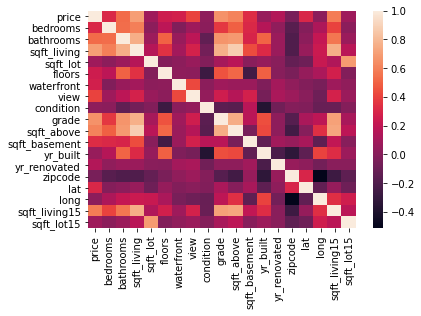

In [ ]:
import seaborn as sns
sns.heatmap(train_df.corr())
# The date information may not be useful

In [ ]:
def random_remove(data1,prob):
    remove_mask = np.random.uniform(0,1,size = data1.shape)
    remove_mask = (remove_mask > prob)*1
    rm_idx = np.nonzero(remove_mask)
    data1[rm_idx] = np.nan
    return data1, remove_mask

Keep the data based on the probability 0.7. In other words, there is a probability of 0.3 that the data will be removed.


In [ ]:
prob = 0.7
vali_data_0 = copy.deepcopy(vali_data)
test_data_0 = copy.deepcopy(test_data)
vali_data_rm,vali_mask = random_remove(vali_data_0,prob)
test_data_rm,test_mask = random_remove(test_data_0,prob)
print(vali_data_rm)
print(test_data_rm)

[[         nan          nan  1.00000e+01 ...          nan  1.32000e+03
   7.62000e+03]
 [ 3.09950e+05          nan          nan ... -1.22035e+02  1.98000e+03
           nan]
 [         nan  4.00000e+00  9.00000e+00 ...          nan  2.07000e+03
           nan]
 ...
 [ 2.57500e+05          nan          nan ... -1.22185e+02          nan
   7.07800e+03]
 [ 3.35950e+05  2.00000e+00  5.00000e+00 ... -1.22386e+02  1.19000e+03
           nan]
 [         nan          nan          nan ... -1.22272e+02          nan
           nan]]
[[ 8.12000e+05          nan  1.20000e+01 ... -1.22064e+02  3.42000e+03
   8.40500e+03]
 [ 6.75000e+05  4.00000e+00  9.00000e+00 ... -1.22097e+02  1.73000e+03
   9.22500e+03]
 [ 8.30000e+05  3.00000e+00  1.10000e+01 ...          nan  3.73000e+03
   1.18400e+04]
 ...
 [ 5.15000e+05  2.00000e+00  3.00000e+00 ...          nan  1.78000e+03
   5.04000e+03]
 [ 6.40000e+05  3.00000e+00          nan ...          nan          nan
   2.97500e+03]
 [         nan  4.00000e+00     

In [ ]:
print(np.sum(np.isnan(vali_data_rm)))
print(np.sum(np.isnan(test_data_rm)))

24733
24846


In [ ]:
X= np.append(train_data,vali_data_rm,axis = 0)
X = np.append(X,test_data_rm,axis = 0)
print(X.shape)
print(X)
X_0= np.append(train_data,vali_data,axis = 0)
X_0 = np.append(X_0,test_data,axis = 0)
print(X_0.shape)
print(X_0)

# use this data instead
# control the probability of the missing data
# notation:
# X: data including missing values for method 1
# X_0: the ground truth for method 1
# train_data: dAE gt
# vali_data: dAE gt
# test_data: dAE gt
# vali_data_rm: dAE mv
# test_data_rmL dAE mv

(21613, 19)
[[ 5.32500e+05  4.00000e+00  9.00000e+00 ... -1.22116e+02  2.12000e+03
   1.02400e+04]
 [ 4.10000e+05  2.00000e+00  3.00000e+00 ... -1.22393e+02  1.31000e+03
   4.08000e+03]
 [ 7.82500e+05  3.00000e+00  9.00000e+00 ... -1.22064e+02  3.21000e+03
   8.40500e+03]
 ...
 [ 5.15000e+05  2.00000e+00  3.00000e+00 ...          nan  1.78000e+03
   5.04000e+03]
 [ 6.40000e+05  3.00000e+00          nan ...          nan          nan
   2.97500e+03]
 [         nan  4.00000e+00          nan ...          nan  2.11000e+03
   3.82500e+03]]
(21613, 19)
[[ 5.32500e+05  4.00000e+00  9.00000e+00 ... -1.22116e+02  2.12000e+03
   1.02400e+04]
 [ 4.10000e+05  2.00000e+00  3.00000e+00 ... -1.22393e+02  1.31000e+03
   4.08000e+03]
 [ 7.82500e+05  3.00000e+00  9.00000e+00 ... -1.22064e+02  3.21000e+03
   8.40500e+03]
 ...
 [ 5.15000e+05  2.00000e+00  3.00000e+00 ... -1.22403e+02  1.78000e+03
   5.04000e+03]
 [ 6.40000e+05  3.00000e+00  1.10000e+01 ... -1.22352e+02  1.53000e+03
   2.97500e+03]
 [ 3.200

For models beside Denoising Autoencoder, all the data points are used throughout the data imputaion process.

Then, to create data set with missing values, we randomly remove entries from the data set in the following way:

1. Randomly selected rows from which we want to remove some items.

2. For each selected row, randomly select items to be removed.

In [ ]:
# num_rows = data.count()[0]
# num_cols = len(data.columns)

# row_to_rmv = np.random.randint(2, size = num_rows)
# for i, j in enumerate(row_to_rmv.tolist()):
#     if j == 1:
#         # i-th row is selected
#         col_to_rmv = np.random.randint(2, size = num_cols)
#         for k, l in enumerate(col_to_rmv.tolist()):
#             if l == 1:
#                 # Remove k-th entry of the i-th row
#                 data_rmv.iloc[i,k] = None

For Denoising Autoencoder:

The data set is divided into training (60%), validation (20%), and testing (20%). All the data in the training set are retained while those in the validation and testing sets contain missing values.

In [ ]:
# num_train = int(num_rows*0.6)
# num_test = int(num_rows*0.2)
# num_val = num_rows - num_train - num_test
# row_to_rmv = np.concatenate((np.zeros(num_train), np.ones(num_val), np.full(num_test, 2)), axis=None)
# row_to_rmv = np.random.permutation(row_to_rmv)

# print(row_to_rmv)
# data_VAE = data.copy()
# # for i, j in enumerate(row_to_rmv.tolist()):
# #     if j >= 1:
# #         # i-th row is selected
# #         col_to_rmv = np.random.randint(2, size = num_cols)
# #         for k, l in enumerate(col_to_rmv.tolist()):
# #             if l >= 1:
# #                 # Remove k-th entry of the i-th row
# #                 data_VAE.iloc[i,k] = None

In [ ]:
# le_ = LabelEncoder()
# le_rmv = LabelEncoder()
# le_VAE = LabelEncoder()
# for key in models:
#     if models[key] == "Classification":
#         data[key] = le_.fit_transform(data[key])
#         data_rmv[key] = le_rmv.fit_transform(data_rmv[key])
#         data_VAE[key] = le_VAE.fit_transform(data_VAE[key])
        # data[key] = data[key].astype('category').cat.codes
        # data[key] = data[key].replace({-1: np.nan})
        # data_rmv[key] = int(data_rmv[key].astype('category').cat.codes)
        # data_rmv[key] = data_rmv[key].replace({-1: np.nan})
        # data_VAE[key] = data_VAE[key].astype('category').cat.codes
        # data_VAE[key] = data_VAE[key].replace({-1: np.nan})

# Note: the data has been changed

# X = data_rmv.copy()
# X_0 = data.copy()
# X_train_VAE = data_VAE.iloc[np.nonzero(row_to_rmv == 0.0)[0], 0:]
# X_val_VAE = data_VAE.iloc[np.nonzero(row_to_rmv == 1.0)[0], 0:]
# X_test_VAE = data_VAE.iloc[np.nonzero(row_to_rmv == 2.0)[0], 0:]
# X_val_VAE.head()

# Supervised Learning

# Classification

1.Mode Classifier

2.Decision Tree Classifier

3.Logistic Regression Classifier

4.K-Nearest Neighbor Classifier

In [44]:
class Mode():
    def predict(self, X):
        counts = Counter(X)
        return counts.most_common(1)[0][0]
        
    def get_err(self, y, y_pred):
        y = np.asarray(y)
        y_pred = np.asarray(y_pred)
        return np.mean((y_pred == y))

In [45]:
class Node:
    def __init__(self, pred_cls):
        self.pred_cls = pred_cls
        self.feat_idx = 0
        self.thres = 0
        self.lchild = None
        self.rchild = None
        
class DecisionTreeClf():
    def __init__(self, max_depth=10):
        self.max_depth = max_depth

    def split(self, X, y):
        m = len(y)
        if m <= 1:
            return None, None

        num_parent = [np.sum(y == c) for c in range(self.num_classes)]

        best_gini = 0
        for n in num_parent:
            best_gini = best_gini + (n / m) ** 2 
        best_gini = 1.0 - best_gini
        best_index, best_thres = None, None

        for idx in range(self.num_feats):
            # Sort
            thres, clses = zip(*sorted(zip(X[:, idx], y)))
            num_l = [0] * self.num_classes
            num_r = num_parent.copy()
            for i in range(1, m):
                c = int(clses[i - 1])
                num_l[c] += 1
                num_r[c] -= 1
                gini_l = 0
                for x in range(self.num_classes):
                    gini_l += (num_l[x] / i) ** 2 
                gini_l = 1.0 - gini_l
                gini_r = 0
                for x in range(self.num_classes):
                    gini_r += (num_r[x] / (m - i)) ** 2 
                gini_r = 1.0 - gini_r
                gini = (i * gini_l + (m - i) * gini_r) / m
                if thres[i] == thres[i - 1]:
                    continue
                if gini < best_gini:
                    best_gini = gini
                    best_index = idx
                    best_thres = (thres[i] + thres[i - 1]) / 2  # midpoint
        return best_index, best_thres     

    def fit(self, X, y):
        self.num_feats = X.shape[1]
        self.num_classes = len(set(y))
        self.tree = self.Treeify(X,y)

    def Treeify(self, X, y, depth=0):
        cls_cnt = [np.sum(y == i) for i in range(self.num_classes)]
        pred_cls = np.argmax(cls_cnt)
        node = Node(pred_cls=pred_cls)
        if depth < self.max_depth:
            idx, thres = self.split(X, y)
            if idx is not None:
                idx_l = X[:, idx] < thres
                X_left = X[idx_l]
                y_left = y[idx_l]
                X_right = X[~idx_l]
                y_right = y[~idx_l]
                node.feat_idx = idx
                node.thres = thres
                node.lchild = self.Treeify(X_left, y_left, depth + 1)
                node.rchild = self.Treeify(X_right, y_right, depth + 1)
        return node

    def predict(self, X):
        return [self._predict(x) for x in X]

    def _predict(self, X):
        node = self.tree
        while node.lchild:
            if X[node.feat_idx] < node.thres:
                node = node.lchild
            else:
                node = node.rchild
        return node.pred_cls
        
# if __name__ == "__main__":
#     import sys
#     from sklearn.datasets import load_iris

#     dataset = load_iris()
#     dt = DecisionTreeClf(max_depth=10)
#     dt.train(dataset.data, dataset.target)
#     print(dt.predict([[0, 0, 5, 1.5]]))

In [46]:
# note
# we use one hot embedding in this classification method
# to generalize it from binary classification to multi-class classification
class LogisticReg:
    def __init__(self,epoch=1000,lr=0.1):
        self.epoch = epoch
        self.lr = lr

    def sigmoid(self,x):
        return 1/(1+np.exp(-x))

    def fit(self,X,y):
        eps = np.finfo(float).eps
        class_num = int(np.max(y)+1)
        print(class_num)
        one_hot_y = np.zeros((len(y),class_num))
        y = np.array(y,dtype=int)
        one_hot_y[np.arange(len(y)),y] = 1
        # print(one_hot_y)

        self.weights = np.random.rand(X.shape[1],class_num)
        self.loss = []
        for i in range(self.epoch):
            y_hat = self.sigmoid(X @ self.weights)
            self.weights = self.weights - self.lr*(X.T @ (y_hat-one_hot_y))#/X.shape[0]
            # print(X.T @ (y_hat-one_hot_y)/X.shape[0])
            self.loss.append(-np.mean(one_hot_y*np.log(self.sigmoid(X @ self.weights)+eps) + (1-one_hot_y)*np.log(1-self.sigmoid(X @ self.weights)+eps)))
        # early stop
            if np.sum(self.lr*(np.abs(X.T @ (y_hat-one_hot_y)))) < 1e-8:
                print('early stop at epoch: ', i)
                break

    def predict(self,X_test,threshold = 0.5):
        y_prob = X_test@self.weights
        y_pred = np.argmax(y_prob,axis=1)
        return y_pred
        
    def get_err(self, y, y_pred):
        return np.mean((y_pred == y))

# x_trn = np.array([[-1,-1], [-1,1], [1,-1], [1,1]])
# y_trn = np.array([0,0,1,1])
# print(x_trn.shape)
# print(y_trn.shape)
# logR = LogisticReg()
# logR.fit(x_trn,y_trn)
# print(logR.predict(x_trn))
# plt.plot(logR.loss)

In [47]:
class KnnClf:
    def __init__(self,k=5):
        self.k = k

    def fit(self, X, y):
        self.x_train = X
        self.y_train = y

    def predict(self, x_test):
        y_pred = []
        for x_t in x_test:
            distance = np.sqrt(np.sum((self.x_train-x_t)**2,axis=1))
            sort_index = np.argsort(distance)
            select_index = sort_index[0:self.k]
            labels = []
            for each in select_index:
                labels.append(self.y_train[each])
            maxlabel = max(labels,key = labels.count)
            y_pred.append(maxlabel)
        return y_pred
    
    def get_err(self, y, y_pred):
        return np.mean((y_pred == y))

# Regression

In [ ]:
class Mean():
    def predict(self, X):
        return np.mean(X)
        
    def get_err(self, y, y_pred):
        return np.mean(np.square(np.asarray(y) - np.asarray(y_pred)))

In [ ]:
class LinearReg:
    def __init__(self, Ws = None, Bs = None):
        self.w = Ws
        self.b = Bs

    def predict(self, X):
        return np.dot(X, self.w) + self.b

    def fit(self, X, y):
        X = np.column_stack((np.ones(X.shape[0],'float'), X))
        self.W = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
        self.w = self.W[1:]
        self.b = self.W[0]

    def get_err(self, y, y_pred):
        return np.mean(np.square(y - y_pred))

class linear_reg:
    def __init__(self,n_iter=1000,lr=5e-4):
        self.n_iter = n_iter
        self.lr = lr

    def fit(self,X,y):
        X = np.insert(X,0,1,axis = 1)
        self.mse = []
        _,n_feature = X.shape
        self.w = np.zeros((n_feature,))
        for i in range(self.n_iter):
            error = np.mean((y - np.dot(X,self.w))**2)
            self.mse.append(error)
            grad_w = -(y - X.dot(self.w)).dot(X)
            self.w -= self.lr * grad_w

    def predict(self,X):
        X = np.insert(X, 0, 1, axis=1)
        y_pred = X.dot(self.w)
        return y_pred

    def get_err(self, y, y_pred):
        return np.mean(np.square(y - y_pred))

In [ ]:
class RidgeReg:
    def __init__(self, Bs = None, Ws = None, lamb = 0.1):
        self.b = Bs
        self.w = Ws
        self.lamb = lamb

    def fit(self, X, y):
        X = np.column_stack((np.ones(X.shape[0],'float'), X))
        self.W = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)
                                             + self.lamb*np.identity(X.shape[1])), X.T), y)
        self.w = self.W[1:]
        self.b = self.W[0]
    
    def predict(self, X):
        return (np.dot(X, self.w) + self.b)

    def get_err(self, y, y_pred):
        return np.mean(np.square(y - y_pred))

class ridge_reg:
    def __init__(self,n_iter=1000,lr=5e-4,l2=0.01):
        self.n_iter = n_iter
        self.lr = lr
        self.l2 = l2

    def fit(self,X,y):
        X = np.insert(X,0,1,axis = 1)
        self.mse = []
        _,n_feature = X.shape
        self.w = np.zeros((n_feature,))
        for i in range(self.n_iter):
            error = np.mean((y - X.dot(self.w))**2)
            self.mse.append(error)
            grad_w = -(y - X.dot(self.w)).dot(X) + self.l2*self.w
            self.w -= self.lr * grad_w

    def predict(self,X):
        X = np.insert(X, 0, 1, axis=1)
        y_pred = X.dot(self.w)
        return y_pred

    def get_err(self, y, y_pred):
        return np.mean(np.square(y - y_pred))

In [ ]:
class LassoReg:
    def __init__(self, Bs = None, Ws = None, lamb = 0.05, num_iter = 100):
        self.b = Bs
        self.w = Ws
        self.lamb = lamb
        self.num_iter = num_iter
        
    # Soft threshold function used for coordinate descent lasso regression 
    def threshold(self, rho_j, lamb, z_j):
        if rho_j > lamb/2:
            return (rho_j - lamb/2)/z_j
        elif rho_j < (-1)*lamb/2:
            return (rho_j + lamb/2)/z_j 
        else:
            return 0.0
        
    def fit(self, X, y):
        X = np.column_stack((np.ones(X.shape[0],'float'), X))
        self.W = np.zeros((X.shape[1],1),'float')
        # Recall from the 2nd question of HW4 that E[\hat{b}] = b
        # and \hat{b} = y_i - \hat{w}x_i,
        # so the bias b = average of (actual y_i - predicted y_i)
        y_pred_0 = np.dot(X[:, 1:], self.W[1:]).flatten()
        self.b = np.sum(y - y_pred_0)/X.shape[0]
        self.W[0] = self.b
        for i in range(self.num_iter):
            for j in range(1,X.shape[1]):
                tmp_w = self.W.copy()
                tmp_w[j] = 0.0 # Exclude w_j
                y_pred = np.dot(X, tmp_w)
                r = y - y_pred.flatten()
                z_j = np.sum(np.square(X[:, j]))
                rho_j = np.dot(X[:, j], r)
                self.W[j] = self.threshold(rho_j, self.lamb*X.shape[0], z_j)
        self.w = self.W[1:]
    
    def predict(self, X):
        return (np.dot(X, self.w) + self.b).flatten()
     
    def get_err(self, y, y_pred):
        return np.mean(np.square(y - y_pred))

In [ ]:
import numpy as np
class Layer():
    def __init__(self,input_dim,output_dim):

        self.weights = np.random.rand(input_dim,output_dim)/np.sqrt(input_dim)
        self.bias = np.zeros(output_dim)

    def forward(self,input_data):
        self.input = input_data
        # print('layer self input',self.input.shape)
        # print('layer self weights',self.weights.shape)
        # print('test',self.bias.shape)
        self.output = self.input @ self.weights +self.bias
        # print('layer self output',self.output.shape)
        # print('self.bias check',self.bias.shape)
        return self.output
    # error: error from next layer
    # new_error: error that will be backwarded to the previous layer
    def backward(self,error,lr):
        # print('self.bias check',self.bias.shape)
        # print('error check',error.shape)
        grad_weight = self.input.T @ error
        grad_bias = np.mean(error,axis=0)*self.input.shape[0]
        grad_bias = grad_bias.reshape(self.bias.shape)
        assert grad_weight.shape == self.weights.shape
        assert grad_bias.shape == self.bias.shape
        self.weights = self.weights - lr*grad_weight
        self.bias = self.bias - lr * grad_bias
        
        # print('self.bias check',self.bias.shape)
        new_error = error @ self.weights.T
        return new_error

class Activate():
    def __init__(self,f,fp):
        self.f = f
        self.fp = fp
    def forward(self,input_data):
        self.input = input_data
        self.output = self.f(self.input)
        return self.output
    def backward(self,error,lr):
        # print('error check',error.shape)
        # print('input check',self.input.shape)
        # print('output check',self.output.shape)
        new_error = self.fp(self.input) * error
        # print('error check',new_error.shape)
        return new_error

class Network:
    def __init__(self,layers):
        self.layers = layers

    def loss_function(self,lf,lfp):
        self.loss = lf
        self.loss_p = lfp

    def predict(self,input_data):
        y_out = input_data
        for layer in self.layers:
            # print('input_for_each_layer',layer,y_out.shape)
            y_out = layer.forward(y_out)
            # print('output_for_each_layer',layer,y_out.shape)
        return y_out
    # we would like to perform SGD in the training process
    def train(self,X,y,epochs,lr,batch_size = 1):

        for i in range(epochs):
            epoch_error = 0

            for j in range(0,len(y),batch_size):
                s = j
                e = min(j+batch_size,len(y))
                X_batch = X[s:e]
                y_batch = y[s:e]
                y_pred = self.predict(X_batch)
                y_batch = y_batch.reshape(y_pred.shape)
                epoch_error += self.loss(y_batch,y_pred)
                error_batch_p = self.loss_p(y_batch,y_pred)

                for layer in reversed(self.layers):
                    # print('back check',layer)
                    # print(error_batch_p.shape)
                    error_batch_p = layer.backward(error_batch_p,lr)
                # if j % 1000 == 0:
                #     print('batch: {}/{}   loss={}'.format(j,len(X),self.loss(y_batch,y_pred)))
            epoch_error = epoch_error/(len(y)/batch_size)
            self.epoch_error = epoch_error
            # if i % 500 == 0:
            #     print('---------------------------')
            #     print('epoch: {}   loss={}'.format(i,epoch_error))

# loss functions
class loss_function_set():
    # MSE loss function:
    # input: y label and y prediction
    # output: a mse value
    def mse(self,y_true,y_pred):
        # value
        return np.mean((y_true-y_pred)**2)

    def mse_p(self,y_true,y_pred):
        # return -2*(np.sum(y_true-y_pred,axis = 0))/len(y_true)
        # [batch,class]
        return -2*(y_true-y_pred)/len(y_true)

        # return -2*(np.sum(y_true-y_pred,axis=0).reshape(1,y_true.shape[1]))/len(y_true)

#activation functions:
class activation_set():
    def tanh(self,x):
        return np.tanh(x)
    def tanh_p(self,x):
        return 1-np.tanh(x)**2
    def relu(self,x):
        return np.maximum(0,x)
    def relu_p(self,x):
        return x>0

   
     
       
    


In [ ]:
# x_trn = np.array([[-1,-1], [-1,1], [1,-1], [1,1],[-1,-1], [-1,1], [1,-1], [1,1]])
# y_trn = np.array([1,-1,-1,1,1,-1,-1,1])

# act_f = activation_set()
# loss_f =loss_function_set()
# # network
# net = Network(layers = [Layer(2, 4),
#                         Activate(act_f.tanh, act_f.tanh_p),
#                         Layer(4, 1),
#                         Activate(act_f.tanh, act_f.tanh_p)
#                         ])
# # train
# net.loss_function(loss_f.mse, loss_f.mse_p)
# net.train(x_trn, y_trn, epochs=1000, lr=0.1,batch_size = 5)

# # test
# out = net.predict(x_trn)
# print(out)

In [ ]:
class KnnReg:
    def __init__(self,k=5):
        self.k = k

    def fit(self, X, y):
        self.x_train = X
        self.y_train = y

    def predict(self, x_test):
        y_pred = []
        for x_t in x_test:
            distance = np.sqrt(np.sum((self.x_train-x_t)**2,axis=1))
            sort_index = np.argsort(distance)
            select_index = sort_index[0:self.k]
            labels = []
            for each in select_index:
                labels.append(self.y_train[each])
            y_pred.append(np.mean(labels))
        return y_pred
    
    def get_err(self, y, y_pred):
        return np.mean(np.square(y - y_pred))



In [ ]:
class Node_reg():
    def __init__(self, X, y, idx, threshold=3):
        self.X = X 
        self.y = y
        self.idx = idx 
        self.threshold = threshold
        self.num_samples = len(idx)
        self.num_feats = X.shape[1]
        self.val = np.mean(y[idx])
        self.wtd_std = float('inf')
        self.split_data()

    def get_wtd_std(self, L, R):
        y = self.y[self.idx]
        return y[L].std() * L.sum() + y[R].std() * R.sum()
             
    def split_feat(self):
        return self.X.values[self.idx, self.feat_idx]
            
    def leaf(self):
        return self.wtd_std == float('inf')

    def split_data(self):
        for ft_i in range(self.num_feats):
            self.get_split(ft_i)
        if self.leaf:
            return
        X = self.split_feat
        self.lchild = Node_reg(self.X, self.y, self.idx[np.nonzero(X <= self.split)[0]], self.threshold)
        self.rchild = Node_reg(self.X, self.y, self.idx[np.nonzero(X > self.split)[0]], self.threshold)

    def get_split(self, feat_idx):
        X = self.X.values[self.idx, feat_idx]
        for p in range(self.num_samples):
            L = X <= X[p]
            R = X > X[p]
            if R.sum() < self.threshold or L.sum() < self.threshold:
                continue
            tmp_wtd_std = self.get_wtd_std(L, R)
            if tmp_wtd_std < self.wtd_std:
                self.feat_idx = feat_idx
                self.wtd_std = tmp_wtd_std
                self.split = X[p]
      
    def predict(self, X):
        return np.array([self._predict(x) for x in X])

    def _predict(self, x):
        if self.leaf:
            return self.val
        if x[self.feat_idx] <= self.split:
            node = self.lchild
        else:
            node = self.rchild
        return node._predict(x)  
        
class DecisionTreeReg():
    def fit(self, X, y, threshold=3):
        X = pd.DataFrame(data = X[0:,0:], index = [i for i in range(X.shape[0])], columns=[str(i) for i in range(X.shape[1])])
        y = pd.Series(y)
        self.dt = Node_reg(X, y, np.array(np.arange(len(y))), threshold)
        return self
  
    def predict(self, X):
        X = pd.DataFrame(data = X[0:,0:], index = [i for i in range(X.shape[0])], columns=[str(i) for i in range(X.shape[1])])
        return self.dt.predict(X.values)


# dt_reg = DecisionTreeReg()
# dt_reg.fit(X_train, y_train)
# y_pred = dt_reg.predict(X_test)
# rmse = np.sqrt(np.sum(np.square(y_test - y_pred)))
# rmse

# Unsupervised Learning
Kmeans

Variational Autoencoder

In [ ]:
class KMeans():
    def __init__(self, k = 5, num_iter = 100, seed = 2020):
        self.k = k
        self.num_iter = num_iter
        np.random.seed(seed)

    def initialize(self, X):
        rand_idx = np.random.permutation(X.shape[0])
        rand_idx = rand_idx[:self.k]
        self.centroids = X[rand_idx]

    def get_labels(self, X):
        dists = pairwise_distances(X, self.centroids, metric = 'euclidean')
        labels = np.argmin(dists, axis = 1)
        return labels

    def update(self, X, labels):
        for cluster in range(self.k):
            X_cluster = X[labels == cluster]
            mean = np.mean(X_cluster, axis = 0)
            self.centroids[cluster] = mean

    def fit(self, X):
        self.initialize(X)
        iters = 0
        while iters <= self.num_iter:
            iters += 1
            labels = self.get_labels(X)
            self.update(X, labels)

    def predict(self, X):
        return self.get_labels(X)

# Experiments

Data Preprocessing

Experiments of method 1

In [ ]:
import numpy as np

class imputation:
    def __init__(self,X,X_0):
        self.X = X
        self.X_0 = X_0
    # order_list: contains the ordered feature cols
    # for example [1,3,2,5,4,0] means col 1 has the least missing value, col 0 has the most

    # def normalization(self,X):
    #     return (X-np.mean(X))/np.std(X,axis = 0),np.mean


    def train_test_split(self,X,f_i,order_list):
        f_i = f_i + 1
        select_features = order_list[:f_i]
        X_part = X[:,select_features]
        X_part_0 = self.X_0[:,select_features]
        train_data = X_part[~np.isnan(X_part).any(axis=1),:]
        test_data = X_part[np.isnan(X_part).any(axis=1),:]

        t = len(train_data)
        X_train = train_data[:int(0.8*t),0:f_i-1]
        y_train = train_data[:int(0.8*t),f_i-1]
        X_vali = train_data[int(0.8*t):,0:f_i-1]
        y_vali = train_data[int(0.8*t):,f_i-1]
        X_test = test_data[:, 0:f_i-1]

        # y test should be the real value instead of the nan value
        y_test = X_part_0[np.isnan(X_part).any(axis=1),f_i-1]
        # record the idx of y_test to do the update
        y_test_idx = np.isnan(X_part).any(axis=1)
        return X_train,y_train,X_vali,y_vali,X_test,y_test,y_test_idx

    def sort_features(self):
        mv_mask = np.isnan(self.X)
        mv_count = np.sum(mv_mask*1,axis = 0)
        order_list = np.argsort(mv_count)
        return order_list

    def mse(self,y_true,y_pred):
        return np.sqrt(np.sum((y_true-y_pred)**2))

    def accuracy(self,y_true,y_pred):
        return np.sum(y_pred==y_true)/len(y_true)

    def update(self,y_imp,y_idx_0,y_idx_1):
        self.X[y_idx_0,y_idx_1] = y_imp


    # models: a list of different models
    def fit(self,model_type,reg_models = None,class_models = None):
        order_list = self.sort_features()
        #start with one full filled column
        if model_type[order_list[0]] == 'Regression':
            if np.sum(np.isnan(self.X[:,order_list[0]])) !=0:
                self.X[np.isnan(self.X[:,order_list[0]]),order_list[0]] = np.mean(self.X[~np.isnan(self.X[:,order_list[0]]),order_list[0]])

        if model_type[order_list[0]] == 'Classification':
            if np.sum(np.isnan(self.X[:,order_list[0]])) !=0:
                self.X[np.isnan(self.X[:,order_list[0]]),order_list[0]] = Counter(self.X[~np.isnan(self.X[:,order_list[0]]),order_list[0]]).most_common(1)[0][0]
        self.results_reg = []
        self.results_clf = []
        for i in range(1,len(order_list)):
            X_train,y_train,X_vali,y_vali,X_test,y_test,y_test_idx = self.train_test_split(self.X,i,order_list)
            print('iter:{} target_feature:{}'.format(i,order_list[i]))
            # model selection:
            # model_type: a pre defined list storing the type of features
            if model_type[order_list[i]] == 'Regression':

                reg_mse_vali = []
                reg_mse_test = []
                y_pred_rec = []
                for model_name in reg_models:
                  # need to change according to different models
                    print("Regression using {}".format(model_name))
                    model = model_name()
                    model.fit(X_train,y_train)
                    y_vali_pred = model.predict(X_vali)
                    reg_mse_vali.append(self.mse(y_vali,y_vali_pred))
                    y_pred = model.predict(X_test)
                    y_pred_rec.append(y_pred)
                    reg_mse_test.append(self.mse(y_test,y_pred))
                    print(self.mse(y_test,y_pred))
                    print(np.mean(y_test))
                    print(self.mse(y_vali,y_vali_pred))
                # print(reg_mse_test)
                self.results_reg.append(reg_mse_test)
                best_model = np.argmin(reg_mse_vali)
                y_imp = y_pred_rec[best_model]
                self.update(y_imp,y_test_idx,order_list[i])
                # check if the data has been imputated
                # print(self.X)

            elif model_type[order_list[i]] == 'Classification':

                acc_vali = []
                acc_test = []
                y_pred_rec = []
                for model_name in class_models:
                    print("Classification using {}".format(model_name))
                  # need to change according to different models
                    model = model_name()
                    model.fit(X_train,y_train)
                    y_vali_pred = model.predict(X_vali)
                    acc_vali.append(self.accuracy(y_vali,y_vali_pred))
                    y_pred = model.predict(X_test)
                    y_pred_rec.append(y_pred)
                    acc_test.append(self.accuracy(y_test,y_pred))
                    print(self.accuracy(y_vali,y_vali_pred))
                self.results_clf.append(acc_test)
                best_model = np.argmax(acc_vali)
                y_imp = y_pred_rec[best_model]
                self.update(y_imp,y_test_idx,order_list[i])

In [ ]:
print(X.shape)
print(X_0.shape)
X_norm = copy.deepcopy(X)
X_norm_0 = copy.deepcopy(X_0)
model_type = []
k = 0
norm_mean = {}
norm_std = {}
for key in models:
    model_type.append(models[key])
    if models[key] == 'Regression':
        norm_mean[k] = np.mean(X[~np.isnan(X[:,k]),k])
        norm_std[k] = np.std(X[~np.isnan(X[:,k]),k])
        X_norm[~np.isnan(X[:,k]),k] = (X[~np.isnan(X[:,k]),k]-norm_mean[k])/norm_std[k]
        X_norm_0[:,k] = (X_0[:,k]-norm_mean[k])/norm_std[k]
    k = k+1
# print(X_norm_0)
# print(X_norm)
reg_models = [LinearReg, RidgeReg, LassoReg, DecisionTreeReg, KnnReg]
class_models = [KnnClf, LogisticReg]


pipe = imputation(X_norm, X_norm_0)
pipe.sort_features()
print(pipe.sort_features())
pipe.fit(model_type, reg_models=reg_models, class_models=class_models)

(21613, 19)
(21613, 19)
[ 2  1 14 18  9 10  8  7 11  5 16 15 17 13  6 12  3  0  4]
iter:1 target_feature:1
Classification using <class '__main__.KnnClf'>
0.4112712975098296
Classification using <class '__main__.LogisticReg'>
13


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning:

overflow encountered in exp



0.4584534731323722
iter:2 target_feature:14
Classification using <class '__main__.KnnClf'>
0.02206461780929866
Classification using <class '__main__.LogisticReg'>
70
0.003940110323089046
iter:3 target_feature:18
Regression using <class '__main__.LinearReg'>
46.015800179087194
0.001149422804150646
66.03220554439432
Regression using <class '__main__.RidgeReg'>
46.015793400262055
0.001149422804150646
66.0321880407064
Regression using <class '__main__.LassoReg'>
46.0052905948963
0.001149422804150646
65.95879739442549
Regression using <class '__main__.DecisionTreeReg'>
46.315877614952235
0.001149422804150646
66.44174150785578
Regression using <class '__main__.KnnReg'>
45.73276584294636
0.001149422804150646
66.34005214167459
iter:4 target_feature:9
Classification using <class '__main__.KnnClf'>
0.4595375722543353
Classification using <class '__main__.LogisticReg'>
12
0.40199684708355227
iter:5 target_feature:10
Regression using <class '__main__.LinearReg'>
35.354846661459234
0.02769902473837

In [ ]:
import plotly.graph_objects as go
sorted_feat = pipe.sort_features()
sorted_feat_cat = []
sorted_feat_num = []
for i in sorted_feat:
    if model_type[i] == "Regression":
        sorted_feat_num.append(train_df.columns[i])
    elif model_type[i] == "Classification":
        sorted_feat_cat.append(train_df.columns[i])

In [ ]:
linear = []
ridge = []
lasso = []
dtreeReg = []
knnReg = []
knnClf = []
logReg = []
# dtreeClf = []

for i in pipe.results_clf:
    knnClf.append(i[0])
    logReg.append(i[1])
    # dtreeClf.append(i[2])

for i in pipe.results_reg:
    linear.append(i[0])
    ridge.append(i[1])
    lasso.append(i[2])
    dtreeReg.append(i[3])
    knnReg.append(i[4])

In [ ]:
lasso

[46.0052905948963,
 47.276568706887765,
 50.077167527990454,
 45.64777276876056,
 49.441397274966086,
 34.6193498168827,
 49.70788362502898,
 37.97370008587256,
 20.7870893887762,
 30.65535194001255,
 44.56475076326165]

In [ ]:
fig = go.Figure(data=[
    go.Bar(name='Linear Regression', x=sorted_feat_num, y=linear),
    go.Bar(name='Ridge Regression', x=sorted_feat_num, y=ridge),
    go.Bar(name='Lasso Regression', x=sorted_feat_num, y=lasso),
    go.Bar(name='Decision Tree', x=sorted_feat_num, y=dtreeReg),
    go.Bar(name='KNN', x=sorted_feat_num, y=knnReg)
])
# Change the bar mode
fig.update_layout(barmode='group', title_text='MSE for each Numerical Feature')
fig.show()

In [ ]:
fig = go.Figure(data=[
    go.Bar(name='KNN', x=sorted_feat_cat, y=knnClf),
    go.Bar(name='Logistic Regression', x=sorted_feat_cat, y=logReg)
    # go.Bar(name='Decision Tree', x=sorted_feat_cat, y=dtreeClf)
])
# Change the bar mode
fig.update_layout(barmode='group', title_text='Accuracy for each Categorical Feature')
fig.show()

In [ ]:
X_new = pipe.X.copy()

In [ ]:
k = 0
for key in models:
    if models[key] == 'Regression':
        X_new[:,k] = X_new[:,k]*norm_std[k] + norm_mean[k]
    k = k + 1

pd.DataFrame(X_new, columns = train_df.columns)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,532500.0,4.0,9.0,2490.0000,8750.000000,2.0,0.0,0.0,2.0,6.0,2040.0,450.000000,76.0,0.0,7.0,47.5931,-122.1160,2120.000000,10240.0
1,410000.0,2.0,3.0,1480.0000,4080.000000,0.0,0.0,0.0,2.0,5.0,1050.0,430.000000,49.0,0.0,51.0,47.6842,-122.3930,1310.000000,4080.0
2,782500.0,3.0,9.0,3750.0000,7821.000000,2.0,0.0,0.0,2.0,7.0,3750.0,0.000000,101.0,0.0,37.0,47.6325,-122.0640,3210.000000,8405.0
3,995000.0,4.0,12.0,3530.0000,20012.000000,2.0,0.0,0.0,2.0,9.0,3530.0,0.000000,86.0,0.0,28.0,47.7193,-122.1270,3850.000000,20707.0
4,279000.0,4.0,9.0,2009.0000,4800.000000,2.0,0.0,0.0,2.0,6.0,2009.0,0.000000,112.0,0.0,40.0,47.2586,-122.2000,1798.000000,4800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,1268900.0,4.0,9.0,3440.0000,14554.000000,2.0,0.0,4.0,2.0,6.0,2170.0,817.256025,112.0,0.0,62.0,47.7364,-122.3540,3170.000000,11810.0
21609,240200.0,3.0,6.0,1500.0000,11968.000000,0.0,0.0,0.0,2.0,4.0,1500.0,38.992304,114.0,0.0,58.0,47.3095,-122.2628,1320.000000,11303.0
21610,515000.0,2.0,3.0,1640.0000,5200.000000,0.0,0.0,0.0,3.0,5.0,1040.0,104.343329,41.8,0.0,69.0,47.6510,-122.3810,1780.000000,5040.0
21611,640000.0,3.0,9.0,1559.4649,1466.000000,4.0,0.0,0.0,2.0,6.0,1560.0,0.000000,111.8,0.0,13.0,47.6604,-122.3368,1671.343343,2975.0


In [ ]:
pd.DataFrame(X_0, columns = train_df.columns)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,532500.0,4.0,9.0,2490.0,8750.0,2.0,0.0,0.0,2.0,6.0,2040.0,450.0,76.0,0.0,7.0,47.5931,-122.116,2120.0,10240.0
1,410000.0,2.0,3.0,1480.0,4080.0,0.0,0.0,0.0,2.0,5.0,1050.0,430.0,49.0,0.0,51.0,47.6842,-122.393,1310.0,4080.0
2,782500.0,3.0,9.0,3750.0,7821.0,2.0,0.0,0.0,2.0,7.0,3750.0,0.0,101.0,0.0,37.0,47.6325,-122.064,3210.0,8405.0
3,995000.0,4.0,12.0,3530.0,20012.0,2.0,0.0,0.0,2.0,9.0,3530.0,0.0,86.0,0.0,28.0,47.7193,-122.127,3850.0,20707.0
4,279000.0,4.0,9.0,2009.0,4800.0,2.0,0.0,0.0,2.0,6.0,2009.0,0.0,112.0,0.0,40.0,47.2586,-122.200,1798.0,4800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,1950000.0,4.0,9.0,3440.0,14554.0,2.0,1.0,4.0,2.0,6.0,2170.0,1270.0,112.0,0.0,62.0,47.7364,-122.286,3170.0,11810.0
21609,224000.0,3.0,6.0,1500.0,11968.0,0.0,0.0,0.0,2.0,4.0,1500.0,0.0,114.0,0.0,8.0,47.3095,-122.002,1320.0,11303.0
21610,515000.0,2.0,3.0,1640.0,5200.0,0.0,0.0,0.0,3.0,5.0,1040.0,600.0,37.0,0.0,69.0,47.6426,-122.403,1780.0,5040.0
21611,640000.0,3.0,11.0,1560.0,1466.0,4.0,0.0,0.0,2.0,6.0,1560.0,0.0,106.0,0.0,42.0,47.6604,-122.352,1530.0,2975.0


In [ ]:
pipe.X.tofile('Data_Interpolated.csv', sep = ',')

Experiment of method 2

In [ ]:
act_f = activation_set()
loss_f =loss_function_set()
# network
def random_remove_0(data1,prob):
    remove_mask = np.random.uniform(0,1,size = data1.shape)
    remove_mask = (remove_mask > prob)*1
    rm_idx = np.nonzero(remove_mask)
    data1[rm_idx] = 0
    return data1, remove_mask
def norm(data,nmean,nstd):
    return (data-nmean)/nstd
def denorm(data,nmean,nstd):
    return data*nstd + nmean
print(test_data.shape)
print(vali_data.shape)
print(train_data.shape)


(4323, 19)
(4323, 19)
(12967, 19)


In [ ]:
norm_mean = np.mean(train_data,axis = 0)
norm_std = np.std(train_data,axis = 0)
train_norm = (train_data-norm_mean)/norm_std
vali_norm = (vali_data-norm_mean)/norm_std
test_norm = (test_data-norm_mean)/norm_std
train_norm_0 = copy.deepcopy(train_norm)
vali_norm_0 = copy.deepcopy(vali_norm)
test_norm_0 = copy.deepcopy(test_norm)
train_norm_rm,train_mask = random_remove_0(train_norm_0,0.7)
test_norm_rm ,test_mask = random_remove_0(test_norm_0,0.7)
vali_norm_rm ,vali_mask = random_remove_0(vali_norm_0,0.7)
print(np.sum(test_mask))
print(train_norm.shape)

24696
(12967, 19)


In [ ]:
net = Network(layers = [Layer(19, 30),
                        Activate(act_f.tanh, act_f.tanh_p),
                        Layer(30, 40),
                        Activate(act_f.tanh, act_f.tanh_p),
                        Layer(40, 20),
                        Activate(act_f.tanh, act_f.tanh_p),
                        Layer(20, 19)
                        ])

# net = Network(layers = [Layer(19, 15),
#                         Activate(act_f.tanh, act_f.tanh_p),
#                         Layer(15, 10),
#                         Activate(act_f.tanh, act_f.tanh_p),
#                         Layer(10, 15),
#                         Activate(act_f.tanh, act_f.tanh_p),
#                         Layer(15, 19)
#                         ])
# # train
net.loss_function(loss_f.mse, loss_f.mse_p)

In [ ]:
loss_train = []
loss_vali = []

loop = 120
for i in range(loop):
    # train_norm_rm,train_mask = random_remove_0(train_norm_0,0.7)
    epoch_num = 200
    net.train(train_norm_rm, train_norm, epochs=epoch_num, lr=5e-4,batch_size = 2000)
    print('epoch:{}'.format((i+1)*epoch_num))
    print('train_loss: ', net.epoch_error)
    loss_train.append(net.epoch_error)
# # validation
    out = net.predict(vali_norm_rm)
    vali_mse = loss_f.mse(vali_norm,out)
    print('vali_loss: ', vali_mse)
    loss_vali.append(vali_mse)
    if vali_mse - loss_vali[i-1] > 0:
        print('over fitting. Early stop at {}.format',(i+1)*epoch_num)

In [ ]:
# loss_train_0_100 = copy.deepcopy(loss_train)
# loss_vali_0_100 = copy.deepcopy(loss_vali)
# net_ori = copy.deepcopy(net)
plt.plot(range(len(loss_train)),loss_train,color='b',label = 'train_loss')
plt.plot(range(len(loss_vali)),loss_vali,color='r',label = 'vali_loss')
plt.legend()
plt.title('train loss vs validation loss for dAE (more hidden units)')
plt.show()

In [ ]:
test_out = net.predict(test_norm_rm)
test_mse = loss_f.mse(test_norm,test_out)
print('test_loss: ', test_mse)

mse_cen_all = np.mean((test_out - test_norm)**2,axis = 0)
plt.bar(range(len(mse_cen_all)),np.sqrt(mse_cen_all))
plt.title('sqrt(mse) for centered features on all records')
plt.show()

In [ ]:
mse_cen_rm = np.sum((test_out - test_norm)**2*test_mask,axis=0)/np.sum(test_mask,axis = 0)
plt.bar(range(len(mse_cen_rm)),np.sqrt(mse_cen_rm))
plt.title('sqrt(mse) for centered features on missing values')
plt.show()

In [ ]:
test_pred = denorm(test_out,norm_mean,norm_std)
test_truth = denorm(test_norm,norm_mean,norm_std)
mse_all = np.mean((test_pred - test_truth)**2,axis = 0)

plt.bar(range(len(mse_all)),np.sqrt(mse_all))
plt.title('sqrt(mse) for each feature on all records')
plt.show()

In [ ]:
relative_mse_all = ((test_pred - test_truth)/np.mean(test_truth,axis = 0))**2
relative_mse_feature_all = np.mean(relative_mse_all,axis = 0)
plt.bar(range(len(relative_mse_feature_all)),np.sqrt(relative_mse_feature_all))
plt.title('relative sqrt(mse) for each feature on all records')
plt.show()

In [ ]:
relative_mse_mv = relative_mse_all*test_mask
relative_mse_features_mv = np.sum(relative_mse_mv,axis = 0)/np.sum(test_mask,axis = 0)
plt.bar(range(len(relative_mse_features_mv)),np.sqrt(relative_mse_features_mv))
plt.title('relative sqrt(mse) for each feature only on missing values')
plt.show()

In [ ]:
test_pred = pd.DataFrame(test_pred,columns=train_df.columns[0:19])
test_pred.head()

In [ ]:
test_truth = pd.DataFrame(test_data,columns=train_df.columns[0:19])
test_truth.head()